## <center>Calculating the sensitivity Parameter</center>

### Contents:
1. Calculation of the mean change in temperature both regionally, on the whole and change in mean temperature of days exceeding xth percentile regionally
2. Plotting of the change in mean temperature of days exceeding xth percentile regionally - and comparison to Byrne 2021
3. Calculating $\alpha$ for land and Ocean for each model and where $\alpha _L$ is a function of percentile of temperature
4. Briefly Plotting $\alpha$ as a function of percentile to see spread and mean
5. Calculating $\gamma^{T_O}$ and infering $\delta T_L^x$ using the Fixed RH portion of the theory
6. Plotting the correlation between predicted $\delta T_L^x$ and simulated $\delta T_L^x$

In [65]:
import math
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import datetime
import os
import cftime
import matplotlib.pyplot as plt
from scipy import stats
import sys
import seaborn as sns
from scipy.stats import linregress, pearsonr
sys.path.append('/home/users/chingosa/Functions/')
import CMIPFuncs as func
from multiprocessing import Pool, cpu_count


def calcEsat(temp):
    '''
    temp must be provided in K
    results returned in Pa
    '''
    return (0.6113 * np.exp(2500000/461*((1/273.15)-(1/temp))))*1000

# Going between Esat and Qsat - bringing in pressure
def calcQsat(temp, pressure):
    '''
    temp provided in K, pressure in Pa
    results returned in kg kg-1 ie 1
    '''
    Esat = calcEsat(temp)/1000 #in kPa
    eps = 0.622
    
    return (eps*Esat) / ((pressure/1000) - (Esat*(1-eps)))


The below code block is calculating the change in temperature for land and ocean over each percentile regionally
there was so initial confusion where I was calculating the change for each percentile over every grid cell and then averaged those changes out regionally 
Some Notes:
- Excacuted using parrellel processing script where each model is saved as percentileDifferences_{model}_flt.csv
- flt is the one that we should be using - the other ones were the change for each percentile over every grid cell averaged for the region (land or ocean)

In [ ]:
###----------------------------------------------------------------------------------------------------------------------------------###
#    This Calc function calculates the change in the mean temperature for days exceeding the xth percentile of temperature             
###----------------------------------------------------------------------------------------------------------------------------------### 

def calc(model):
    variables = ['tas']
    period = ['ssp245', 'historical']
    percentiles = [1,2,5,10,15,25,35,45,55,65,75,85,90,95,98,99]
    df = pd.DataFrame(columns=['percentile', 'model', 'landOcean', 'tChange', 'meanChangeRg', 'meanChangeAll'])

    print(model)

    #this reads in the data one var at a time, makes a ds - trims it and assigns to ds_ssp245 and ds_hist
    for period in period:
        for var in variables:
            ds_merge = xr.open_mfdataset(func.getVariable(var, model, period))
            if var == variables[0]: ds = ds_merge
            else: ds = xr.merge([ds, ds_merge[var]])
        del ds_merge   
        
        # Cut down region and add Land Mask
        ds = func.regionTimeCut(ds, period) 
        ds = func.addLandMask(ds)
        
        if    period == 'ssp245': 
            ds_ssp245 = ds
        elif  period == 'historical': 
            ds_hist   = ds
    del ds

    #mean change all is the mean temperature change between ssp245 and historical
    meanChangeAll= (ds_ssp245.tas.mean(['lat', 'lon', 'time']) - ds_hist.tas.mean(['lat', 'lon', 'time'])).to_numpy()

    # for each region...
    for LandOcean in [0, 1]:
        #Calculates the difference between the means above the xth percentile for land and ocean seperatly
        dif = func.mean_above_percentiles(ds_ssp245.where(ds_ssp245.landseamask == LandOcean).tas.to_numpy().flatten(), percentiles) - func.mean_above_percentiles(ds_hist.where(ds_hist.landseamask == LandOcean).tas.to_numpy().flatten(), percentiles)
        
        # this does the mean change for either land or ocean - no percentiles
        meanChangeRg = (ds_ssp245.tas.where(ds_ssp245.landseamask == LandOcean).mean(['lat', 'lon', 'time']) - ds_hist.tas.where(ds_hist.landseamask == LandOcean).mean(['lat', 'lon', 'time'])).to_numpy()
        
        # manages the collected data
        df_add_land = pd.DataFrame({'percentile': percentiles, 'model': model, 'landOcean': LandOcean, 'tChange': dif, 'meanChangeRg': meanChangeRg, 'meanChangeAll': meanChangeAll})
        df = pd.concat([df, df_add_land], ignore_index = True)

    # saves to csv as
    df.to_csv(f'percentileDifferences_{model}_flt.csv', index=False)
    
###----------------------------------------------------------------------------------------------------------------------------------###
#        Loading Model Names and Running the Calculation
###----------------------------------------------------------------------------------------------------------------------------------### 
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')

for model in modelNames.ModelName: calc(model)

# Once all models are run - collect the individual csv files for each models and colate them into percentileDifferences_all_flt.csv
df = pd.DataFrame({})
for model in modelNames.ModelName:
    df_add = pd.read_csv(f'percentileDifferences_{model}_flt.csv')
    df = pd.concat([df, df_add], ignore_index=True)
    
df.to_csv('percentileDifferences_all_flt.csv')

### Using change in temperature calculations to recreate figure 2 from Byrne 2021

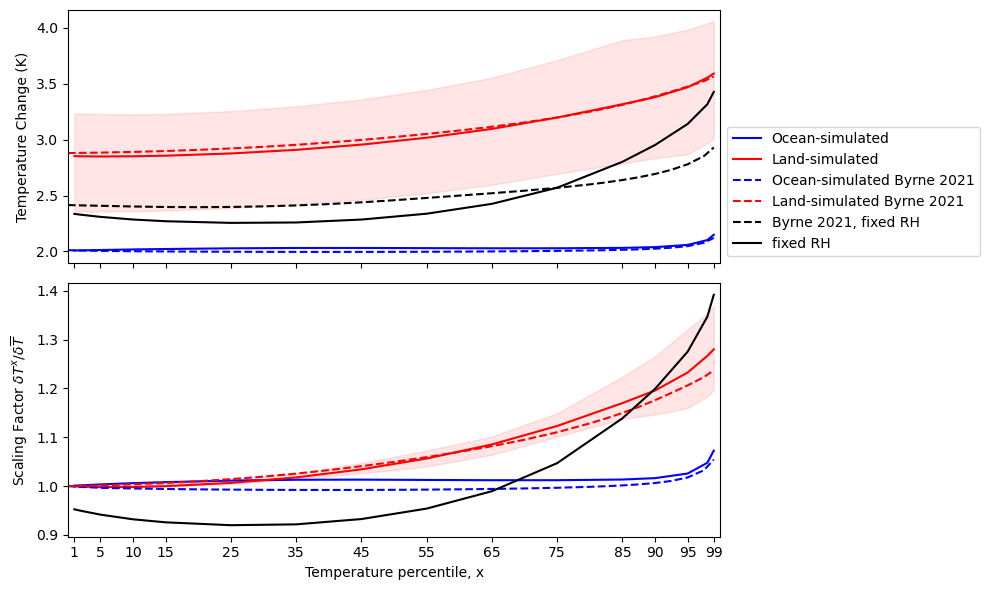

In [7]:
Show_Byrne = True
doFixRH = True
## Reloading Data and Calculating Scaling factors and quantiles
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')

###----------------------------------------------------------------------------------------------------------------------------------###
#        Processing percentileDifferences_all_flt.csv
###----------------------------------------------------------------------------------------------------------------------------------### 

df = pd.read_csv(f'percentileDifferences_all_flt.csv')
df['tChange_sf'] = df.tChange/df.meanChangeRg

df_mean = df.groupby(['landOcean', 'percentile'], as_index = False).tChange.mean()
df_mean[['q1', 'q3']] = df.groupby(['landOcean', 'percentile'], as_index = False).tChange.agg(q1 = lambda x: np.percentile(x, 25),
                                                                                              q3 = lambda x: np.percentile(x, 75))[['q1', 'q3']]

df_mean['sf_mean'] = df.groupby(['landOcean', 'percentile'], as_index = False).tChange_sf.mean().tChange_sf
df_mean[['sf_q1', 'sf_q3']] = df.groupby(['landOcean', 'percentile'], as_index = False).tChange_sf.agg(q1 = lambda x: np.percentile(x, 25),
                                                                                              q3 = lambda x: np.percentile(x, 75))[['q1', 'q3']]
df_mean.head()

###----------------------------------------------------------------------------------------------------------------------------------###
#       Plotting your own data to recreate Figure 2 from Byrne 2021
###----------------------------------------------------------------------------------------------------------------------------------### 
# Initalize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex = True)

#ax1
ax1.fill_between(df_mean.percentile[df_mean['landOcean'] == 1], df_mean.q1[df_mean['landOcean'] == 1], df_mean.q3[df_mean['landOcean'] == 1], color='r', alpha = 0.1)
for i in [0,1]:
    ax1.plot(df_mean.percentile[df_mean['landOcean'] == i], df_mean.tChange[df_mean['landOcean'] == i], color = ['b', 'r'][i], label = ['Ocean-simulated', 'Land-simulated'][i])

#ax2
ax2.fill_between(df_mean.percentile[df_mean['landOcean'] == 1], df_mean.sf_q1[df_mean['landOcean'] == 1], df_mean.sf_q3[df_mean['landOcean'] == 1], color='r', alpha = 0.1)
for i in [0,1]:
    ax2.plot(df_mean.percentile[df_mean['landOcean'] == i], df_mean.sf_mean[df_mean['landOcean'] == i], color = ['b', 'r'][i])
###----------------------------------------------------------------------------------------------------------------------------------###
#     Processing Byrne 2021 Data
###----------------------------------------------------------------------------------------------------------------------------------### 
if Show_Byrne:
    df_Byrne = pd.read_csv('41561_2021_828_MOESM4_ESM.csv')
    
    for i in [0,1]:
        ax1.plot(df_Byrne['# Panel (a): X data'], df_Byrne[['Panel (a): Y data (solid blue line)', 'Panel (a): Y data (solid red line)'][i]], color = ['b', 'r'][i], label = ['Ocean-simulated Byrne 2021', 'Land-simulated Byrne 2021'][i], linestyle = '--')
        ax2.plot(df_Byrne['Panel (b): X data'], df_Byrne[['Panel (b): Y data (solid blue line)', 'Panel (b): Y data (solid red line)'][i]], color = ['b', 'r'][i], linestyle = '--')
    
    if doFixRH: ax1.plot(df_Byrne['# Panel (a): X data'], df_Byrne['Panel (a): Y data (dotted black line)'], c = 'k', linestyle = '--', label = 'Byrne 2021, fixed RH')

###----------------------------------------------------------------------------------------------------------------------------------###
#    Processing our fixRH calculations of dT_L^x
###----------------------------------------------------------------------------------------------------------------------------------### 
if doFixRH:
    Fix_RH = pd.read_csv(f'Fixed_RH_Theory_All.csv')
    Fix_RH_means = Fix_RH.groupby(['percentile'], as_index=False).dT_L_x.mean()
    ax1.plot(Fix_RH_means.percentile, Fix_RH_means.dT_L_x, c = 'k', label = 'fixed RH')

    df = pd.read_csv(f'percentileDifferences_all_flt.csv')
    df = df.query('landOcean == 1').reset_index(drop=True)
    
    Fix_RH['tChange_sf'] = Fix_RH.dT_L_x/df.meanChangeRg
    Fix_RH_means = Fix_RH.groupby(['percentile'], as_index=False).tChange_sf.mean()
    ax2.plot(Fix_RH_means.percentile, Fix_RH_means.tChange_sf, c = 'k')

#Labels, Axis, legend
ax1.legend(loc = 3, bbox_to_anchor = (1, 0))

ax1.set_xlim(0,100)
ax1.set_ylabel('Temperature Change (K)')
ax2.set_ylabel('Scaling Factor $\delta T^x / \delta \overline{T}$')
ax2.set_xlabel('Temperature percentile, x')
ax2.set_xticks(df_mean.percentile[df_mean['landOcean'] == 1][~df_mean.percentile[df_mean['landOcean'] == 1].isin([2,98])])
fig.tight_layout()
fig.show()


##### Some Notes about the figure above ^
- The top part of the figure looks nearly identical however the bottom one does not
- There are some noticable differences in the character of the scaling factor in the lowest percentiles of temperature
- The mean temperature change here is defined as the mean temperature difference between the ssp245 and historical simulation regionally (ie land and ocean done seperatly)
- Especially the lines being the other way around in the lowest percentiles is pretty weird


---
---
# Plan for Implimenting the Fixed Relative Humidity Theory

##### Fully equation we are going for...
This is the simplified version of the theory assuming a fixed RH over land:

$\delta T_L^x = \gamma ^{T_O} \delta T_O$


$\gamma ^{T_O} = \dfrac{(c_p + L_v \alpha_O q_O)}{(c_p + L_v \alpha _L q_L^x)}$

With...

$ \alpha _L = \dfrac{(\dfrac{\delta q_{L.sat}^x}{q_{L.sat}^x})}{\delta T_L^x}  $      

$ \alpha _O = \dfrac{(\dfrac{\delta q_{O.sat}}{q_{O.sat}})}{\delta T_O} $

$ \alpha _L $ is the clausius clapeyron parameters defining the fractional sensitvities of land saturation specific humidities to a 1 K temperature change

##### Context ... what we are trying to do?
- we are using $\delta T_L^x$ as the dependant variable in the future climate
- and for all intensive purposes $\gamma ^{T_O}$ will be our explainatory variable - the sensitivity parameter
- everything in the expression for $\gamma ^{T_O}$ can be calculated from variables in the current climate except for $\alpha _L$ and $\alpha _O$ which need the change in temperature
- However I imagine the clausius clapeyron parameter for land and ocean end up being pretty similar between models are hopefully reionally homogenious allowing us to just use the mean value there



##### Variable types to worry about here
1) MOPs - means over percentiles
   - $\delta T_L^x$
2) Conditioned MOP - mean of a variable of days over where temperature exceeds the xth percentile
   - $q_L^x$
   - $q_{L.sat}^x$ -hist

In [ ]:
### Stitching these calculations together and looking at the spread between models
# The intention here is to see how close together these values are so that we can be more confident parameterizing them in our emergent constraint
# Future analysis also might try and look and how alpha_L varies spatially as I imagine it might but for now just using one value 

###---------------------------------------------------------------------------------------------------------------------------------------------------###
#      This calculation function uses the above formulas to determine the values of alpha for land and ocean - land is multiple values - by percentile
###---------------------------------------------------------------------------------------------------------------------------------------------------### 
def calc(model):
    percentiles = [1,2,5,10,15,25,35,45,55,65,75,85,90,95,98,99]
    variables = ['tas', 'huss', 'psl']
    periods = ['ssp245', 'historical']
    print(model)
    ## Reading in Data, Calculating q_sat, merging and outputting as ds_ssp245 and ds_hist
    for period in periods:
        for var in variables:
            ds_merge = xr.open_mfdataset(func.getVariable(var, model, period), chunks={"time": 1})
            if var == variables[0]: ds = ds_merge
            else: ds = xr.merge([ds, ds_merge[var]])
        del ds_merge
        # Calculate q_sat
        ds['q_sat'] = ((0.622*(0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds['tas']))))) / ((ds['psl']/1000) - ((0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds['tas']))))*(1-0.622))))
            
        # Cut down region and add Land Mask
        ds = func.regionTimeCut(ds, period) 
        ds = func.addLandMask(ds)
        
        if    period == 'ssp245': 
            ds_ssp245 = ds
        elif  period == 'historical': 
            ds_hist   = ds
    del ds
    
    ## Calculating alpha_O
    dT_O = ds_ssp245.tas.where(ds_ssp245.landseamask == 0).mean(['time', 'lat', 'lon']) - ds_hist.tas.where(ds_hist.landseamask == 0).mean(['time', 'lat', 'lon'])
    
    dq_Osat = ds_ssp245.q_sat.where(ds_ssp245.landseamask == 0).mean(['time', 'lat', 'lon']) - ds_hist.q_sat.where(ds_hist.landseamask == 0).mean(['time', 'lat', 'lon'])
    
    q_Osat = ds_hist.q_sat.where(ds_hist.landseamask == 0).mean(['time', 'lat', 'lon'])
    
    alpha_O = ((dq_Osat/q_Osat) / dT_O).to_numpy()
    
    ## Calculating alpha_L
    dT_x_L = func.mean_above_percentiles(ds_ssp245.where(ds_ssp245.landseamask == 1).tas.to_numpy().flatten(), percentiles) - func.mean_above_percentiles(ds_hist.where(ds_hist.landseamask == 1).tas.to_numpy().flatten(), percentiles)
    
    q_x_Lsat_ssp245 = func.mean_above_percentiles_difVar(ds_ssp245.where(ds_ssp245.landseamask == 1).tas.to_numpy().flatten(), ds_ssp245.where(ds_ssp245.landseamask == 1).q_sat.to_numpy().flatten(), percentiles)
   
    q_x_Lsat_hist = func.mean_above_percentiles_difVar(ds_hist.where(ds_hist.landseamask == 1).tas.to_numpy().flatten(), ds_hist.where(ds_hist.landseamask == 1).q_sat.to_numpy().flatten(), percentiles)
    
    dq_x_Lsat = q_x_Lsat_ssp245 - q_x_Lsat_hist
    
    alpha_L = (dq_x_Lsat / q_x_Lsat_hist) / dT_x_L
    
    ## Sticking it all in a dataframe for analysis
    df = pd.DataFrame({'model': model, 'percentile': percentiles, 'alpha_O': alpha_O, 'alpha_L': alpha_L})
    df.to_csv(f'alpha_varience_{model}.csv', index=False)

###----------------------------------------------------------------------------------------------------------------------------------###
#     Using calc to generate resultant dataframes for all models describing alpha for land and ocean
###----------------------------------------------------------------------------------------------------------------------------------### 
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')

for model in modelNames.ModelName: calc(model)

# cleaning up individual dataframes and saving as alpha_varience_All.csv
df = pd.DataFrame({})

for model in modelNames.ModelName:
    df_add = pd.read_csv(f'alpha_varience_{model}.csv')
    df = pd.concat([df, df_add], ignore_index=True)
    
df.to_csv('alpha_varience_All.csv')

### Plotting Alpha varience

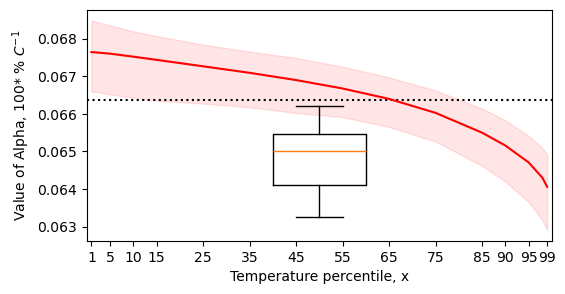

In [45]:
###----------------------------------------------------------------------------------------------------------------------------------###
#   Plotting the Alpha varience as a function of percentiles
###----------------------------------------------------------------------------------------------------------------------------------### 

df = pd.read_csv('alpha_varience_All.csv')
df_mean = df.groupby(['percentile'], as_index = False).alpha_L.mean()
df_mean[['q1', 'q3']] = df.groupby(['percentile'], as_index = False).alpha_L.agg(q1 = lambda x: np.percentile(x, 25),
                                                                                 q3 = lambda x: np.percentile(x, 75))[['q1', 'q3']]

# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(6, 3))
ax1.axhline([df_mean.alpha_L.mean()], color = 'k', linestyle = ':')
ax1.fill_between(df_mean.percentile, df_mean.q1, df_mean.q3, color='r', alpha = 0.1)

ax1.plot(df_mean.percentile, df_mean.alpha_L, c='r')
ax1.boxplot(df.alpha_O, positions=[50], widths = [20])

ax1.set_xticks(df_mean.percentile[~df_mean.percentile.isin([2,98])], labels=df_mean.percentile[~df_mean.percentile.isin([2,98])])
ax1.set_xlabel('Temperature percentile, x')
ax1.set_xlim(0,100)
ax1.set_ylabel('Value of Alpha, 100* % $C^{-1}$')
fig.show()


Alpha - the clausius clapeyron parameter quantifies the fractional sensitivity of saturation specific humidity over land to a 1K tmperature change#
- In the above graph the line represents the average value of $\alpha _L$ at each temperature percentile for all models
- the box and whisker plot represents the values of $\alpha _O$ for all models

The take away is that its all pretty darn close together

### A little confusion on the aim here...
- So we can likely parameterize alpha pretty well here
- But odds are we won't be able to parameterize dT_O particularly well
- The change in the xth percentile is discribed in two parts - first being the sensitivity which we are able (with alpha parameterized) to constrain without knowlege of the future climate, and the second is the change in ocean temperature

###### Getting around that
I think the way of getting around this issue is that because the sensitivity parameter is basically just the coeffecient to multiply the oceananic temperature change by, and since you can't include the oceanic temperature change in the x variable you would need to do some sort of amplification or scaling factor as the y variable?

Essentially what youd want to be testing for at least the no RH change version of the theory is if the dT_L^x is more due to differences in dT_O or the sensitivity parameter

## Pressing foreward towards the fixed RH theory

This is the simplified version of the theory assuming a fixed RH over land:

$\delta T_L^x = \gamma ^{T_O} \delta T_O$


$\gamma ^{T_O} = \dfrac{(c_p + L_v \alpha_O q_O)}{(c_p + L_v \alpha _L q_L^x)}$

In [ ]:
###----------------------------------------------------------------------------------------------------------------------------------###
#     This calc function impliments the above gamma and dT_L^x formula and saves it to individual dataframes
###----------------------------------------------------------------------------------------------------------------------------------### 
def calc(model):
    # Constants and variable lists
    cp = 1004.6
    Lv = 2500000
    percentiles = [1,2,5,10,15,25,35,45,55,65,75,85,90,95,98,99]
    variables = ['tas', 'huss']
    periods = ['historical']
    alpha_all = pd.read_csv('alpha_varience_All.csv')
    df_dTO = pd.read_csv('percentileDifferences_all_flt.csv', index_col=0)
    alpha_all_mean = alpha_all.groupby('percentile').alpha_L.mean()
    
    ## Reading in Data, merging and outputting as ds_ssp245 and ds_hist
    for period in periods:
        for var in variables:
            ds_merge = xr.open_mfdataset(func.getVariable(var, model, period))
            if var == variables[0]: ds = ds_merge
            else: ds = xr.merge([ds, ds_merge[var]])
        del ds_merge
        
        # Cut down region and add Land Mask
        ds = func.regionTimeCut(ds, period) 
        ds = func.addLandMask(ds)
        
        if    period == 'ssp245': 
            ds_ssp245 = ds
        elif  period == 'historical': 
            ds_hist   = ds
                  
    del ds
    print('data loaded')
    
    q_O = ds_hist.where(ds_hist.landseamask == 0).huss.mean(['time', 'lat', 'lon']).to_numpy()
    q_L_x = func.mean_above_percentiles_difVar(ds_hist.where(ds_hist.landseamask == 1).tas.to_numpy().flatten(), ds_hist.where(ds_hist.landseamask == 1).huss.to_numpy().flatten(), percentiles)
    
    a_O = alpha_all.alpha_O[alpha_all.model == model].iloc[0]
    
    a_L = alpha_all.alpha_L[alpha_all.model == model].values
    # a_L = alpha_all_mean.alpha_L

    #Final Part of calculation
    top = (cp + (Lv*a_O*q_O))
    # --------------------------- = y
    bottom = (cp + (Lv*a_L*q_L_x))
    
    gamma = top/bottom

    
    dT_O = df_dTO[(df_dTO.model == model) & (df_dTO.landOcean == 0)].meanChangeRg.iloc[0]
    
    dT_L_x = dT_O*gamma
    
    df = pd.DataFrame({'model': model, 'percentile': percentiles, 'gamma': gamma, 'dT_O': dT_O, 'dT_L_x': dT_L_x})
    df.to_csv(f'Fixed_RH_Theory_{model}.csv', index=False)
    print('done')
    
###----------------------------------------------------------------------------------------------------------------------------------###
#   Using calc to generate resultant dataframes for all models calculating gamma - and the infered dT_L^x from changes in ocean temp
###----------------------------------------------------------------------------------------------------------------------------------### 
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')
for model in modelNames.ModelName: calc(model)

df = pd.DataFrame({})
for model in modelNames.ModelName:
    df_add = pd.read_csv(f'Fixed_RH_Theory_{model}.csv')
    df = pd.concat([df, df_add])

df.to_csv('Fixed_RH_Theory_All.csv', index = False)

## Plotting $\delta T_L^x$ - theory vs simulated

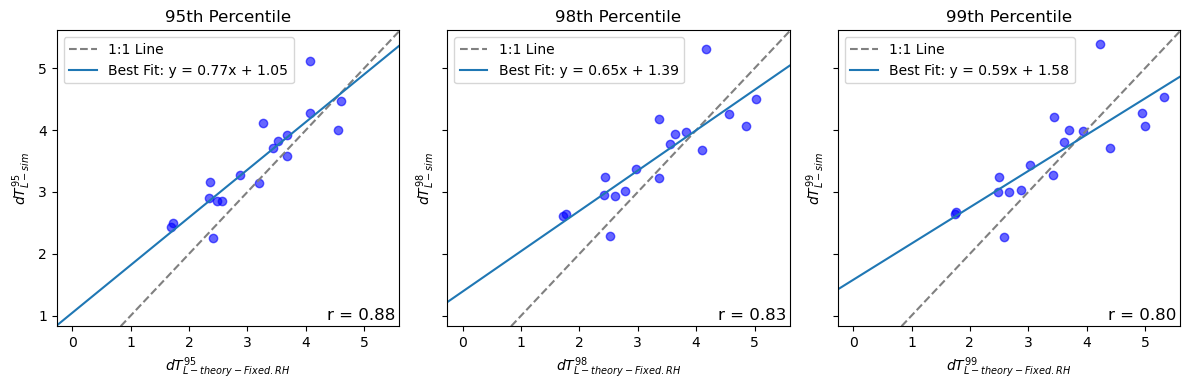

In [22]:
# Define percentiles to use for each subplot
percentiles = [95, 98, 99]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

# Loop over each percentile and create a subplot
for i, percentile in enumerate(percentiles):
    # Load and filter the fixed RH theory dataset for the current percentile
    df_FRH = pd.read_csv('Fixed_RH_Theory_All.csv')
    df_FRH = df_FRH[df_FRH.percentile == percentile].reset_index(drop=True)

    # Load and filter the simulated dataset for the current percentile
    df_sim = pd.read_csv('percentileDifferences_all_flt.csv', index_col=[0])
    df_sim = df_sim[(df_sim.landOcean == 1) & (df_sim.percentile == percentile)].reset_index(drop=True)
    
    # Scatter plot for the current percentile
    axes[i].scatter(df_FRH.dT_L_x, df_sim.tChange, color='blue', alpha=0.6)

    # 1:1 Line (y=x)
    
    axes[i].axline((df_FRH.dT_L_x.mean(), df_FRH.dT_L_x.mean()), slope=1, linestyle='--', label="1:1 Line", color='grey')

    # Line of best fit
    slope, intercept, _, _, _ = linregress(df_FRH.dT_L_x, df_sim.tChange)
    axes[i].axline(xy1 = (0,intercept), slope = slope, label=f"Best Fit: y = {slope:.2f}x + {intercept:.2f}")


    # Correlation coefficient
    corr, _ = pearsonr(df_FRH.dT_L_x, df_sim.tChange)
    axes[i].text(.99, .01, f"r = {corr:.2f}", ha='right', va='bottom', transform=axes[i].transAxes, fontsize=12)
    # Set labels and title for each subplot
    axes[i].set_title(f"{percentile}th Percentile")
    axes[i].set_xlabel(f"$dT^{{{percentile}}}_{{L-theory - Fixed.RH}}$")
    axes[i].set_ylabel(f"$dT^{{{percentile}}}_{{L-sim}}$")
    
    # Add legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


## Plotting $\gamma^{T_O}$ versus $\delta T_L^x$ - simulated

0.09551287010753166
0.09921887817624654
0.09377441222295269


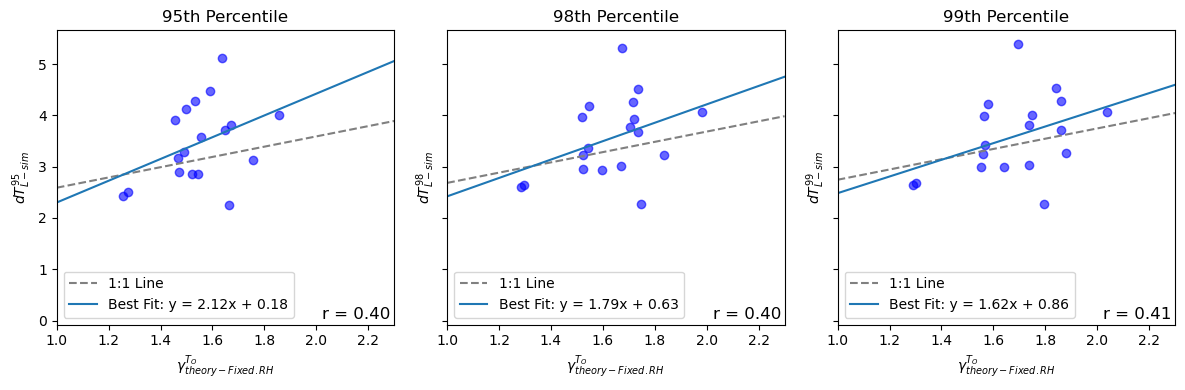

In [28]:
# Define percentiles to use for each subplot
percentiles = [95, 98, 99]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

# Loop over each percentile and create a subplot
for i, percentile in enumerate(percentiles):
    # Load and filter the fixed RH theory dataset for the current percentile
    df_FRH = pd.read_csv('Fixed_RH_Theory_All.csv')
    df_FRH = df_FRH[df_FRH.percentile == percentile].reset_index(drop=True)

    # Load and filter the simulated dataset for the current percentile
    df_sim = pd.read_csv('percentileDifferences_all_flt.csv', index_col=[0])
    df_sim = df_sim[(df_sim.landOcean == 1) & (df_sim.percentile == percentile)].reset_index(drop=True)
    
    # Scatter plot for the current percentile
    axes[i].scatter(df_FRH.gamma, df_sim.tChange, color='blue', alpha=0.6)

    # 1:1 Line (y=x)
    
    axes[i].axline((df_FRH.gamma.mean(), df_FRH.dT_L_x.mean()), slope=1, linestyle='--', label="1:1 Line", color='grey')

    # Line of best fit
    slope, intercept, _, _, _ = linregress(df_FRH.gamma, df_sim.tChange)

    axes[i].axline(xy1 = (0,intercept), slope = slope, label=f"Best Fit: y = {slope:.2f}x + {intercept:.2f}")

    # Correlation coefficient
    corr, p = pearsonr(df_FRH.gamma, df_sim.tChange)
    axes[i].text(.99, .01, f"r = {corr:.2f}", ha='right', va='bottom', transform=axes[i].transAxes, fontsize=12)
    # Set labels and title for each subplot
    axes[i].set_title(f"{percentile}th Percentile")
    axes[i].set_xlabel(f"$\gamma^{{T_O}}_{{theory - Fixed.RH}}$")
    axes[i].set_ylabel(f"$dT^{{{percentile}}}_{{L-sim}}$")
    axes[i].set_xlim(1,2.3)
    # Add legend
    axes[i].legend()
    print(p)

# Adjust layout
plt.tight_layout()
plt.show()


In [48]:
percentiles = [1,2,5,10,15,25,35,45,55,65,75,85,90,95,98,99]
variables = ['tas', 'huss']
periods = ['historical']
alpha_all = pd.read_csv('alpha_varience_All.csv')
df_dTO = pd.read_csv('percentileDifferences_all_flt.csv', index_col=0)
alpha_all_mean = alpha_all.groupby('percentile').alpha_L.mean()

## Reading in Data, merging and outputting as ds_ssp245 and ds_hist
for period in periods:
    for var in variables:
        ds_merge = xr.open_mfdataset(func.getVariable(var, model, period))
        if var == variables[0]: ds = ds_merge
        else: ds = xr.merge([ds, ds_merge[var]])
    del ds_merge
    
    # Cut down region and add Land Mask
    ds = func.regionTimeCut(ds, period) 
    ds = func.addLandMask(ds)
    
    if    period == 'ssp245': 
        ds_ssp245 = ds
    elif  period == 'historical': 
        ds_hist   = ds

In [53]:
def mean_above_percentiles_difVar(data, dataCon, percentiles):
    import xarray as xr
    import numpy as np
    # Calculate the threshold for each percentile
    thresholds = np.nanpercentile(data, percentiles, axis=-1)
    print(thresholds)
    thresholds = np.nanpercentile(data, percentiles)
    print(thresholds)
    return
    means = np.full_like(percentiles, np.nan, dtype=np.float64)  # Pre-allocate array for means

    # Calculate mean for values above each threshold
    for i, threshold in enumerate(thresholds):
        above_threshold = dataCon[data > threshold]
        if above_threshold.size > 0:
            means[i] = np.nanmean(above_threshold)
            
    return means

mean_above_percentiles_difVar(ds_hist.where(ds_hist.landseamask == 1).tas.to_numpy().flatten(), ds_hist.where(ds_hist.landseamask == 1).huss.to_numpy().flatten(), percentiles)









[282.15405701 285.73629761 289.08621216 291.45211792 292.82675171
 294.58682251 295.78527832 296.72787476 297.56796265 298.42822266
 299.55197144 301.53811646 303.05630493 305.17953491 307.22024536
 308.36407471]
[282.15405701 285.73629761 289.08621216 291.45211792 292.82675171
 294.58682251 295.78527832 296.72787476 297.56796265 298.42822266
 299.55197144 301.53811646 303.05630493 305.17953491 307.22024536
 308.36407471]


        model     gamma      dT_O    dT_L_x  percentile
0  ACCESS-CM2  1.209809  2.447876  2.961462           1
1  ACCESS-CM2  1.205910  2.447876  2.951917           2
2  ACCESS-CM2  1.196495  2.447876  2.928871           5
3  ACCESS-CM2  1.186206  2.447876  2.903685          10
4  ACCESS-CM2  1.180564  2.447876  2.889874          15


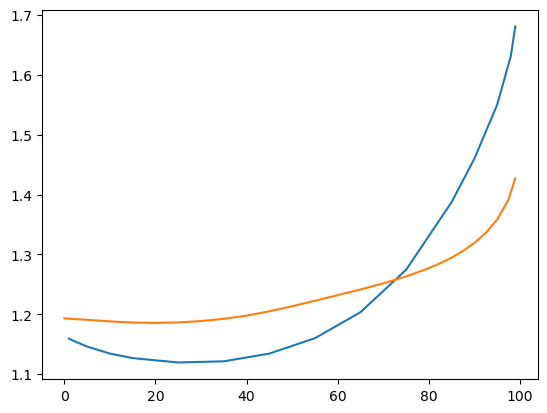

In [60]:
df_FRH = pd.read_csv('Fixed_RH_Theory_All.csv')
print(df_FRH.head())
df_FRH_mean = df_FRH.groupby('percentile', as_index=False).gamma.mean()

plt.plot(df_FRH_mean.percentile, df_FRH_mean.gamma)

df = pd.read_csv('41561_2021_828_MOESM10_ESM.csv', index_col=None)
plt.plot(df['Panel (a): Y data (solid black line)'], df['# Panel (a): X data'])


### Recreating extended Data Figure 6

In [ ]:
def calc(model):
    print(model)
    # Constants and variable lists
    percentiles = [1,2,5,10,15,25,35,45,55,65,75,85,90,95,98,99]
    variables = ['tas', 'huss']
    periods = ['historical', 'ssp245']
    
    ## Reading in Data, merging and outputting as ds_ssp245 and ds_hist
    for period in periods:
        for var in variables:
            ds_merge = xr.open_mfdataset(func.getVariable(var, model, period))
            if var == variables[0]: ds = ds_merge
            else: ds = xr.merge([ds, ds_merge[var]])
        del ds_merge
        
        # Cut down region and add Land Mask
        ds = func.regionTimeCut(ds, period) 
        ds = func.addLandMask(ds)
        
        if    period == 'ssp245': 
            ds_ssp245 = ds
        elif  period == 'historical': 
            ds_hist   = ds
                  
    del ds

    q_L_x_hist = func.mean_above_percentiles_difVar(ds_hist.where(ds_hist.landseamask == 1).tas.to_numpy().flatten(), ds_hist.where(ds_hist.landseamask == 1).huss.to_numpy().flatten(), percentiles)
    q_O_x_hist = func.mean_above_percentiles_difVar(ds_hist.where(ds_hist.landseamask == 0).tas.to_numpy().flatten(), ds_hist.where(ds_hist.landseamask == 0).huss.to_numpy().flatten(), percentiles)

    q_L_x_ssp245 = func.mean_above_percentiles_difVar(ds_ssp245.where(ds_ssp245.landseamask == 1).tas.to_numpy().flatten(), ds_ssp245.where(ds_ssp245.landseamask == 1).huss.to_numpy().flatten(), percentiles)
    q_O_x_ssp245 = func.mean_above_percentiles_difVar(ds_ssp245.where(ds_ssp245.landseamask == 0).tas.to_numpy().flatten(), ds_ssp245.where(ds_ssp245.landseamask == 0).huss.to_numpy().flatten(), percentiles)

    T_L_x_hist = func.mean_above_percentiles(ds_hist.where(ds_hist.landseamask == 1).tas.to_numpy().flatten(), percentiles)
    T_O_x_hist = func.mean_above_percentiles(ds_hist.where(ds_hist.landseamask == 0).tas.to_numpy().flatten(), percentiles)

    T_L_x_ssp245 = func.mean_above_percentiles(ds_ssp245.where(ds_ssp245.landseamask == 1).tas.to_numpy().flatten(), percentiles)
    T_O_x_ssp245 = func.mean_above_percentiles(ds_ssp245.where(ds_ssp245.landseamask == 0).tas.to_numpy().flatten(), percentiles)

    df = pd.DataFrame({'model': model,
                       'percentile': percentiles,
                       'q_L_x_hist': q_L_x_hist,
                       'q_O_x_hist': q_O_x_hist,
                       'q_L_x_ssp245': q_L_x_ssp245,
                       'q_O_x_ssp245': q_O_x_ssp245,
                       'T_L_x_hist': T_L_x_hist,
                       'T_O_x_hist': T_O_x_hist,
                       'T_L_x_ssp245': T_L_x_ssp245,
                       'T_O_x_ssp245': T_O_x_ssp245}
                       )
    df.to_csv(f'q_and_t_percentiles_{model}.csv')
    
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')
for model in modelNames.ModelName: calc(model)

df = pd.DataFrame({})
for model in modelNames.ModelName:
    df_add = pd.read_csv(f'q_and_t_percentiles_{model}.csv')
    df = pd.concat([df, df_add])

df.to_csv('q_and_t_percentiles__All.csv', index = False)

In [68]:
df = pd.read_csv('q_and_t_percentiles__All.csv', index)
df.head()

,Unnamed: 0,model,percentile,q_L_x_hist,q_O_x_hist,q_L_x_ssp245,q_O_x_ssp245,T_L_x_hist,T_O_x_hist,T_L_x_ssp245,T_O_x_ssp245
0,0,ACCESS-CM2,1,0.011971,0.016503,0.014152,0.019274,298.686798,299.612183,302.358429,302.061768
1,1,ACCESS-CM2,2,0.012030,0.016557,0.014213,0.019337,298.815857,299.673096,302.485565,302.125244
2,2,ACCESS-CM2,5,0.012181,0.016699,0.014367,0.019504,299.108154,299.828125,302.774902,302.281891
3,3,ACCESS-CM2,10,0.012357,0.016901,0.014526,0.019737,299.492859,300.037598,303.159393,302.494354
4,4,ACCESS-CM2,15,0.012464,0.017073,0.014609,0.019936,299.827698,300.215668,303.497620,302.674103
